In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

En este caso de estudio analizaremos la distribución de nombres en Argentina desde 1912 a 2015. Los datos fueron tomados de [datos.gob.ar](https://datos.gob.ar/dataset/otros-nombres-personas-fisicas/archivo/otros_2.1).

El set de datos contiene el listado histórico de los nombres registrados ante el Registro Nacional de las Personas agrupados por nombre y año. Por ejemplo "Maria" y "Maria Luisa" son entradas diferentes.

In [2]:
df = pd.read_csv('datos/nombres.zip')
df.head()

,nombre,cantidad,año
0,Maria,314,1922
1,Rosa,203,1922
2,Jose,163,1922
3,Maria Luisa,127,1922
4,Carmen,117,1922


Podemos usar describe para obtener un resúmen de los datos, como por ejemplo que tenemos más de 9.7 millones de entradas. Y que el nombre más popular, en un año, fue registrado 7939 veces.

In [3]:
df.describe()

,cantidad,año
count,9.761609e+06,9.761609e+06
mean,6.177199e+00,1.980137e+03
std,4.336806e+01,2.429556e+01
min,1.000000e+00,1.922000e+03
25%,1.000000e+00,1.961000e+03
50%,2.000000e+00,1.985000e+03
75%,3.000000e+00,2.001000e+03
max,7.939000e+03,2.015000e+03


Veamos cual fue ese nombre y en que año se dio el registro

In [4]:
df[df["cantidad"] == 7939]

,nombre,cantidad,año
3673344,Leonel Hernan,7939,1975


Antes de continuar nos vamos a asegurar de unificar nombres con y sin tilde y vamos a asegurarnos que solo la primer letra de cada nombre es mayúscula.

In [5]:
trans = str.maketrans('áéíóúäëïöüâêîôûàèìòùãẽĩõũ', 'aeiou'*5) # this can be done with the unidecode library


df["nombre"] = (df["nombre"].str.replace("[\(].*?[\)]", "", regex=True)
                            .str.lower()
                            .str.translate(trans)
                            .str.title()
                            .str.rstrip()
               )

Vamos a quedarnos solo con los datos cuyos nombres tengan una longitud mayor a 2.

In [6]:
df = df[df["nombre"].str.len() > 2]

Y vamos a revisar si tenemos entradas marcadas como datos perdidos

In [7]:
df.isna().sum()

nombre      0
cantidad    0
año         0
dtype: int64

El set de datos original contenía algunos valores, pero estos fueron eliminados en la liempieza que hicimos anterioremente. Si todavía tuvieramos datos faltantes podríamos haberlos esliminado haciendo

```python
df.dropna(inplace=True)
```

Es posible seguir normalizando y limpiando estos datos, ya que hay varias anomalías en los nombres. Cómo números, nombres incompletos etc. A los fines de este ejemplo consideraremos que todas esas anomalías ocurren con suficiente baja probabilidad como para no afectar el resultado de nuestro análisis.

## Algunos nombres con patrones particulares

Es común que la mayoría de los nombres sean populares durante solo un periodo relativamente corto de tiempo. Muchas veces la popularidad de los nombres se relaciona con eventos históricos o de la cultura popular.

Veamos por ejemplo como cambio la frecuencia del nombre "Diego Armando"

In [8]:
df_diego = df[df["nombre"] == "Diego Armando"]

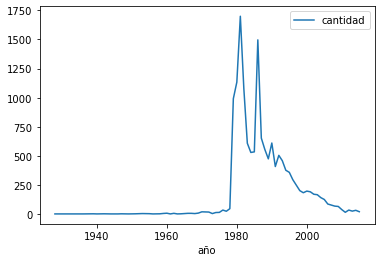

In [9]:
df_diego.plot(x="año", y="cantidad");

No es sorpresa que la popularidad de este nombre esté estrechamente vinculada a la popularidad de Diego Armándo Maradona y a su trayectoria profesional como futbolísta, por ejemplo vemos como el primer pico se vincula con su entrada al equipo de Boca Juniors (1981-1982) y el segundo pico al mundial de fútbol celebrado en México en el año 1986.

In [10]:
df_diego_sorted = df_diego.sort_values("cantidad", ascending=False)
df_diego_sorted.head()

,nombre,cantidad,año
4331462,Diego Armando,1699,1981
4989636,Diego Armando,1496,1986
4259954,Diego Armando,1133,1980
4458306,Diego Armando,1078,1982
4135435,Diego Armando,991,1979


Otro nombre que muestra un perfil muy particular es "Malvina". En este caso en vez de buscar exactamente el nombre "Malvina", vamos a buscar cualquier nombre que lo contenga, es decir contaremos como válida "Malvina" pero tambien nombres como "Maria Malvina".

In [11]:
df_malvina = df[df["nombre"].str.contains("Malvina")]
df_malvina.head()

,nombre,cantidad,año
1489,Maria Malvina,2,1922
4072,Malvina Maria Gracia,1,1922
8944,Malvina,1,1922
16978,Erminda Malvina,1,1923
17099,Malvina Olga,1,1923


Como en cada año tenemos más de una instancia de "Malvina", necesitamos agrupar por año y sumar las cantidades

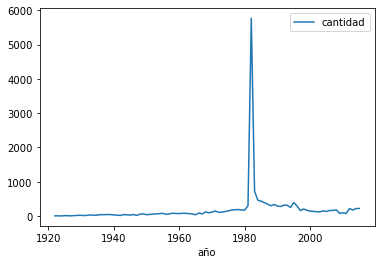

In [12]:
df_malvina = df_malvina.groupby("año").sum().reset_index()
df_malvina.plot(x="año", y="cantidad");

## Cuáles han sido los nombres más populares por año?

Ahora veremos cual es el nombre más popular en cada año, para ello creamos una función que ordena las cantidades de forma descendente y luego toma los primeros `num` elementos.

Luego agrupamos por año y aplicamos la función. Por último reseteamos el índice (hacemos que vuelva a ser de 0 a la cantidad de años -1).

In [13]:
def top_n(group, num):
    return group.sort_values("cantidad", ascending=False)[:num]

top1 = df.groupby(["año"]).apply(top_n, 1).reset_index(drop=True)

A fin de facilitar la visualización del resultado omitimos la columna `cantidad`, transponemos el DataFrame (cambiamos filas por columnas) y ocultamos las columnas (que antes era el índice).

In [14]:
top1[["nombre", "año"]].T.style.hide(axis="columns")

nombre,Maria,Maria,Maria,Maria,Maria,Maria,Maria,Maria,Maria,Maria,Maria,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Norma Beatriz,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Juan Carlos,Miguel Angel,Juan Carlos,Miguel Angel,Miguel Angel,Leonel Hernan,Miguel Angel,Miguel Angel,Miguel Angel,Maria Laura,Maria Laura,Maria Laura,Juan Pablo,Maria Laura,Maria Laura,Juan Manuel,Maria Belen,Maria Belen,Maria Belen,Maria Florencia,Maria Belen,Maria Belen,Maria Belen,Maria Belen,Maria Belen,Maria Belen,Maria Belen,Maria Belen,Agustin,Valentina,Valentina,Valentina,Valentina,Valentina,Valentina,Valentina,Valentina,Valentina,Valentina,Benjamin,Benjamin,Benjamin,Benjamin,Benjamin,Benjamin,Benjamin
año,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015


Ahora vamos a agregar una columna "prop" a nuestro DataFrame, indicando la proporción que cada nombre representa del total de nombres por año.

In [15]:
def add_prop(grupo):
    grupo["prop"] = grupo["cantidad"] / grupo["cantidad"].sum()
    return grupo

df = df.groupby("año").apply(add_prop)

Revisamos que las proporciones den 1 por año, para todos los años

In [16]:
(df.groupby("año").sum()["prop"] == 1).mean()

1.0

Ahora vamos a graficar la distribución a los largo del tiempo de 4 de los nombres más populares, "Maria", "Juan Carlos", "Valentina" y "Benjamin".

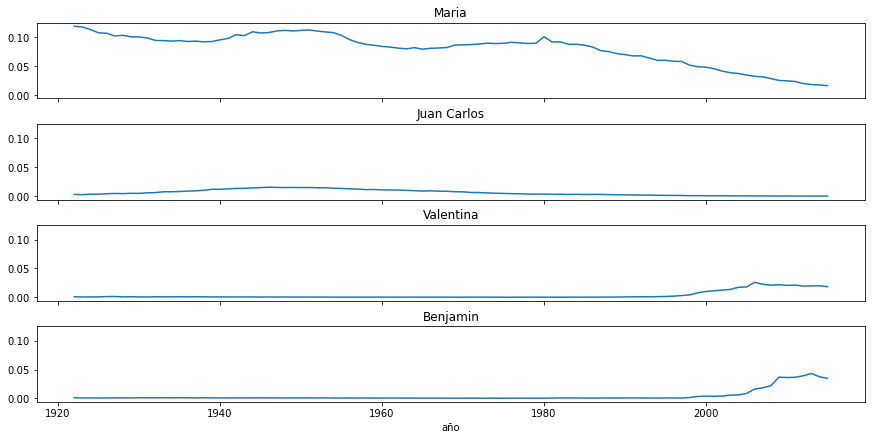

In [17]:
nombres = ["Maria", "Juan Carlos", "Valentina", "Benjamin"]
_, axes = plt.subplots(len(nombres), sharex=True, sharey=True, figsize=(12, 6), constrained_layout=True)

for nombre, ax in zip(nombres, axes):
    (df[df["nombre"].str.contains(nombre)].groupby("año")
                                          .sum()
                                          .reset_index()
                                          .plot("año", 
                                                "prop", ax=ax, legend=False, title=nombre))

En la figura anterior hemos indicado que queremos compartir el `eje-y` entre los distintos subplots. Esto tiene la ventaja de simplificar la comparación entre subplots. Pero hay veces que puede ser preferible dejar que cada subplot tenga sus propios valores para el `eje-y`. En esos casos es conveniente indicar que la escala no es compartida.

## Diversidad de nombres

No solo la popularidad de cada nombre sigue modas y refleja cambios culturales. La diversidad de los nombres también puede variar en el tiempo. Hay mayor diversidad de nombres ahora que hace un siglo? 

Para responder a este interrogante empecemos por calcular la proporción de cada nombre por año

In [18]:
def add_prop(group):
    group["prop"] = group["cantidad"] / group["cantidad"].sum()
    return group

df = df.groupby(["año"]).apply(add_prop)

Podemos corroborar que para cada año la suma da 1

In [19]:
df.groupby(["año"])["prop"].sum().describe()

count    94.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: prop, dtype: float64

In [20]:
df.head()

,nombre,cantidad,año,prop
0,Maria,314,1922,0.013269
1,Rosa,203,1922,0.008578
2,Jose,163,1922,0.006888
3,Maria Luisa,127,1922,0.005367
4,Carmen,117,1922,0.004944


Ahora calcularemos cuales son los 1000 nombres más populares por año.

In [21]:
top1000 = df.groupby(["año"]).apply(top_n, 1000).reset_index(drop=True)
top1000  # podemos ver que la cantidad total de filas es 94 * 1000

,nombre,cantidad,año,prop
0,Maria,314,1922,0.013269
1,Rosa,203,1922,0.008578
2,Jose,163,1922,0.006888
3,Maria Luisa,127,1922,0.005367
4,Carmen,117,1922,0.004944
...,...,...,...,...
93995,Martin Ezequiel,71,2015,0.000090
93996,Ian Maximiliano,71,2015,0.000090
93997,Zoe Yazmin,71,2015,0.000090
93998,Isabella Francesca,71,2015,0.000090


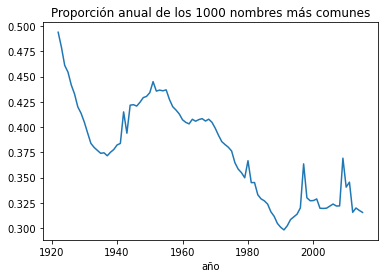

In [22]:
prop_año = top1000.groupby("año")["prop"].sum()
prop_año.plot(title="Proporción anual de los 1000 nombres más comunes",
           #yticks=np.linspace(0, 0.5, 5)
          );

Una forma alternativa de explorar esta pregunta es calcular cual es la cantidad mínima de nombres para obtener el 50% de la proporción total de nombres por año.


Para calcular esta cantidad, primero tenemos que ordenar las proporciones en orden descendente. Luego calculamos la suma acumulada de la proporción (que va de 0 a 1 siempre creciendo). Por último contamos cuantos valores de la suma acumulada son menores o iguales a 0.5 y los sumamos.

In [23]:
def cum_count(grupo, q=0.5):
    grupo = grupo.sort_values("prop", ascending=False)
    return (grupo.prop.cumsum() <= 0.5).sum() 

diversidad = df.groupby(["año"]).apply(cum_count)

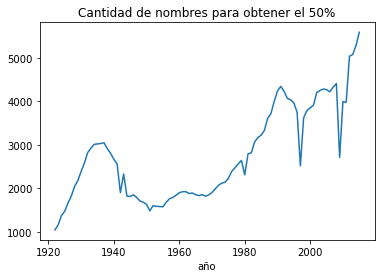

In [24]:
diversidad.plot(title="Cantidad de nombres para obtener el 50%");

## Longitud de los nombres

Ahora exploraremos la longitud de los nombres y su cambio con lo años

In [25]:
def longitud(group):
    group["len"] = group["nombre"].str.len()
    return group

df = df.groupby(["año"]).apply(longitud)

Y el nombre más largo registrado en Argentina es...

In [26]:
df[df["len"] == df["len"].max()]["nombre"].values

array(['Josina Livina Dolores Lucia Carmen Balduina Yolanda Maria Inmaculada Gislena Javiera'],
      dtype=object)

Ahora veamos cual es la distribución de la longitud de nombres, para esto usaremos un histograma junto un con "rug plot" (o gráfico de alfombra). Hacemos esto para ayudar a destacar la larga cola de la distribución de nombres. Dado que las longitudes son discretas hemos decidido usar un bin para cada longitud observada.

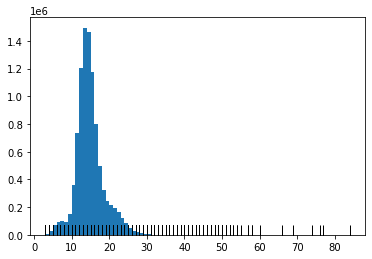

In [27]:
longitudes = df["len"].values
plt.hist("len", data=df, bins=np.unique(longitudes))
plt.plot(longitudes, np.zeros_like(longitudes), "k|", ms=20);

Ahora vemos el cambio en el tiempo

In [28]:
df_len_summary = df.groupby('año').agg(
                                       mean=('len', np.mean),
                                       std=('len', np.std)
                                       ).reset_index()


df_len_summary.head()

,año,mean,std
0,1922,12.850658,3.766880
1,1923,12.932770,3.763134
2,1924,13.045494,3.778390
3,1925,13.079113,3.707827
4,1926,13.185431,3.648110


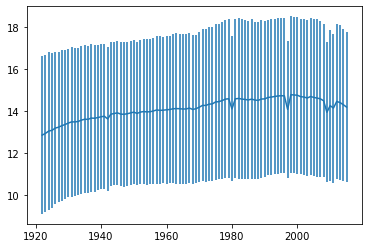

In [29]:
plt.errorbar("año", "mean", "std", data=df_len_summary);